# Applying Filtering and Coarse-Graining to Generate Low Resolution Datasets

Now that we've run our high resolution simulations, we can apply the different filtering and coarse-graining operators examined in the paper to generate low resolution datasets from these simulations.

In [ ]:
import xarray as xr
import fsspec
import numpy as np
import matplotlib.pyplot as plt
import pyqg
import pyqg_parameterization_benchmarks.coarsening_ops as coarsening

%matplotlib inline

We must first initialize a high resolution model. It is from the simulations run on the high resolution model that we will generate filtered and coarsened low resolution simulations that approximate or generalize to simulations made on low resolution initialized models. Below we are using the same eddy-configured high resolution model from the preceding section and running it through without stopping.

In [2]:
high_res_eddy_model = pyqg.QGModel(nx=256, dt=3600.0, tmax=311040000.0, tavestart=155520000.0, log_level=0)
high_res_eddy_model.run()

We now initialize our filtering and coarse-graining operators. Each of the following operators are defined in more detail within the paper. The operator methods take in two parameters: the high resolution model to be filtered and coarsened and the resolution at which to filter and coarsen down to. We will be taking our high resolution simulations with a grid of $256\times256$ and coarsening them down to low resolution simulations with a grid of $64\times64$.

In [ ]:
op1 = coarsening.Operator1(high_res_eddy_model, 64) # spectral truncation + sharp filter
op2 = coarsening.Operator2(high_res_eddy_model, 64) # spectral truncation + softer Gaussian filter
op3 = coarsening.Operator3(high_res_eddy_model, 64) # GCM-Filters + real-space coarsening
ops = [op1, op2, op3]

We can retrieve the filtered and coarsened, low-resolution simulations as `pyqg.QGModel` instances from each of the above operators and convert them into `xarray.Dataset` objects. 

In [4]:
op1.m2.to_dataset()

<xarray.Dataset>
Dimensions:  (time: 1, lev: 2, y: 64, x: 64, l: 64, k: 33, lev_mid: 1)
Coordinates:
  * time     (time) float64 0.0
  * lev      (lev) int32 1 2
  * lev_mid  (lev_mid) float64 1.5
  * x        (x) float64 7.812e+03 2.344e+04 3.906e+04 ... 9.766e+05 9.922e+05
  * y        (y) float64 7.812e+03 2.344e+04 3.906e+04 ... 9.766e+05 9.922e+05
  * l        (l) float64 0.0 6.283e-06 1.257e-05 ... -1.257e-05 -6.283e-06
  * k        (k) float64 0.0 6.283e-06 1.257e-05 ... 0.0001948 0.0002011
Data variables: (12/14)
    q        (time, lev, y, x) float64 1.401e-05 1.213e-05 ... -1.569e-06
    u        (time, lev, y, x) float64 -0.008942 -0.006497 ... -0.005061
    v        (time, lev, y, x) float64 0.007663 0.05587 ... 0.002228 0.00155
    ufull    (time, lev, y, x) float64 0.01606 0.0185 ... -0.007105 -0.005061
    vfull    (time, lev, y, x) float64 0.007663 0.05587 ... 0.002228 0.00155
    qh       (time, lev, l, k) complex128 (0.002072670353054697+0j) ... (-1.4...
    ...       ...
    ph       (time, lev, l, k) complex128 0j ... (3.6140127424424826e-13-2.07...
    dqhdt    (time, lev, l, k) complex128 0j 0j 0j 0j 0j 0j ... 0j 0j 0j 0j 0j
    Ubg      (lev) float64 0.025 0.0
    Qy       (lev) float64 1.039e-10 -7.222e-12
    dqdt     (time, lev, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    p        (time, lev, y, x) float64 -2.08e+03 -1.559e+03 ... -190.3 -164.4
Attributes: (12/23)
    pyqg:beta:       1.5e-11
    pyqg:delta:      0.25
    pyqg:del2:       0.8
    pyqg:dt:         3600.0
    pyqg:filterfac:  23.6
    pyqg:L:          1000000.0
    ...              ...
    pyqg:tc:         0
    pyqg:tmax:       1576800000.0
    pyqg:twrite:     1000.0
    pyqg:W:          1000000.0
    title:           pyqg: Python Quasigeostrophic Model
    reference:       https://pyqg.readthedocs.io/en/latest/index.html

## Utilizing Preexisting Datasets

As promised, we will discuss the structure of the remaining sub-directories housing the cloud-hosted datasets.

```
eddy/
    high_res.zarr
    low_res.zarr
    forcing1.zarr
    forcing2.zarr
    forcing3.zarr
jet/
    high_res.zarr
    low_res.zarr
    forcing1.zarr
    forcing2.zarr
    forcing3.zarr
```

`low_res.zarr` contains snapshots and diagnostics for low resolution eddy- and jet-configured models (where `nx=64`). We can run low resolution simulations in the same manner in which we've previously ran our high resolution simulations with the modification of changing the argument value for the `nx` parameter defined in the `pyqg.QGModel` class when initializing our model.

`forcing{1,2,3}.zarr` contain high resolution snapshots that have been filtered and coarsened down to low resolution, along with relevant information on subgrid forcing variables. There are three of these datasets due to the fact that we explored applying three different filtering and coarse-graining operations on the high resolution simulations. Each dataset corresponds respectively to the three filtering and coarse-graining operators we initialized. 

In [ ]:
def get_dataset(path, base_url="https://g-402b74.00888.8540.data.globus.org"):
    mapper = fsspec.get_mapper(f"{base_url}/{path}.zarr")
    return xr.open_zarr(mapper, consolidated=True)

# Load a small subset of the subgrid forcing data
eddy_forcing1 = get_dataset('eddy/forcing1').isel(run=0).load() # Computed with Operator 1
eddy_forcing2 = get_dataset('eddy/forcing2').isel(run=0).load() # Computed with Operator 2

Each of the forcing datasets, include additional variables that detail the underlying deviations between the high resolution model and its coarsened complement (where $\overline{(\,)}$ denotes the coarse-graining operator):

- `q_subgrid_forcing`: $S_q \equiv \overline{(\mathbf{u} \cdot \nabla)q} - (\overline{\mathbf{u}} \cdot \overline{\nabla})\overline{q}$
- `u_subgrid_forcing`: $S_u \equiv \overline{(\mathbf{u} \cdot \nabla)u} - (\overline{\mathbf{u}} \cdot \overline{\nabla})\overline{u}$
- `v_subgrid_forcing`: $S_v \equiv \overline{(\mathbf{u} \cdot \nabla)v} - (\overline{\mathbf{u}} \cdot \overline{\nabla})\overline{v}$
- `uq_subgrid_flux`: $\phi_{uq} \equiv \overline{uq} - \bar{u}\bar{q}$
- `vq_subgrid_flux`: $\phi_{vq} \equiv \overline{vq} - \bar{v}\bar{q}$. 
- `uu_subgrid_flux`: $\phi_{uu} \equiv \overline{u^2} - \bar{u}^2$
- `vv_subgrid_flux`: $\phi_{vv} \equiv \overline{v^2} - \bar{v}^2$
- `uv_subgrid_flux`: $\phi_{uv} \equiv \overline{uv} - \bar{u}\bar{v}$. 
- `dqdt_bar`: PV tendency from the high-resolution model, filtered and coarsened to low resolution
- `dqbar_dt`: PV tendency from the low-resolution model, initialized at $\overline{q}$. 

In [ ]:
plt.figure(figsize=(12,5)).suptitle("Subgrid forcing with filtering and coarse-graining schemes")
plt.subplot(121); eddy_forcing1.q_subgrid_forcing.isel(lev=1, time=-1).plot(
    cbar_kwargs=dict(label="Upper PV Forcing [$s^{-2}$]"))
plt.title("eddy/forcing1")
plt.subplot(122); eddy_forcing2.q_subgrid_forcing.isel(lev=1, time=-1).plot(
    cbar_kwargs=dict(label="Upper PV Forcing [$s^{-2}$]"))
plt.title("eddy/forcing2")
plt.tight_layout()

## Visualizing Effects

We can visualize the effects on various state variables and resulting subgrid forcing terms from applying the three different methods of filtering and coarse-graining respectively to high resolution eddy configurations.

In [3]:
# Helper function to display plots
def imshow(arr, vlim=3e-5):
    plt.xticks([]); plt.yticks([])
    return plt.imshow(arr, vmin=-vlim, vmax=vlim, cmap='bwr', interpolation='none')

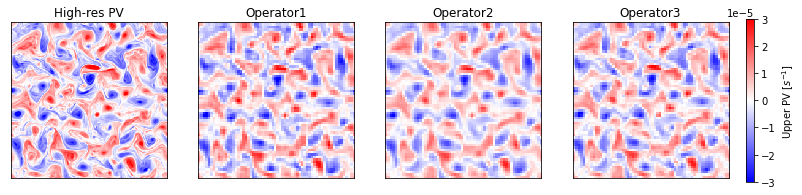

In [15]:
# Visualizing effects on upper-level PV
fig = plt.figure(figsize=(15.5,3))
plt.subplot(1,4,1, title='High-res PV')
imshow(high_res_eddy_model.q[0])
for j, op in enumerate(ops):
    plt.subplot(1,4,j+2, title=op.__class__.__name__)
    im = imshow(op.m2.q[0])
fig.colorbar(im, ax=fig.axes, pad=0.02).set_label('Upper PV [$s^{-1}$]')

From each of the resulting coarsened PV snapshots, it is difficult to see the differences that distinguish them. We can turn to looking at the subgrid forcing to better depict the contrast. We can attain the forcing by calling `subgrid_forcing()` which takes in a state variable, as a string, to compute the subgrid forcing of.

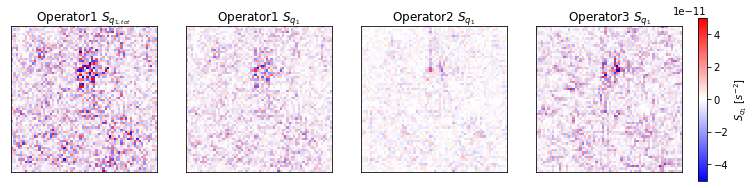

In [22]:
# Visualizing effects on upper PV forcing term
fig = plt.figure(figsize=(14.5,3))
plt.subplot(1,4,1, title='Operator1 $S_{q_{1,tot}}$')
imshow(op1.q_forcing_total[0], 3e-11)
for j, op in enumerate(ops):
    plt.subplot(1,4,j+2, title=op.__class__.__name__ + " $S_{q_1}$")
    im = imshow(op.subgrid_forcing('q')[0], 5e-11)
cb = fig.colorbar(im, ax=fig.axes, pad=0.02).set_label('$S_{q_1}$ [$s^{-2}$]')

We can also compute subgrid flux terms with respect to $u$ and $v$, the $x$- and $y$- velocities relative to the background flow, by calling `subgrid_fluxes()` which similarily also takes in a state variable, as a string, to compute the subgrid flux of. 

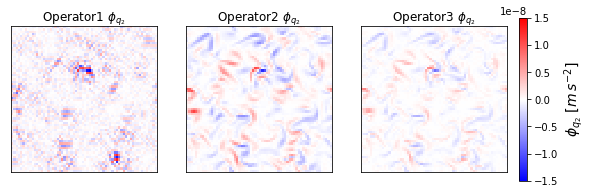

In [20]:
# Visualizing x-component of the lower-layer PV subgrid flux
fig = plt.figure(figsize=(14.5,3))
for j, op in enumerate(ops):
    plt.subplot(1,4,j+1, title=op.__class__.__name__ + " $\phi_{q_2}$")
    uq, vq = op.subgrid_fluxes('q')
    im = imshow(uq[1], 1.5e-8)
fig.colorbar(im, ax=fig.axes, pad=0.02).set_label('$\phi_{q_2}$ [$m\,s^{-2}$]', fontsize=14)

## Troubleshooting 
The following sections provides some potential solutions to any issues come across when attempting to run any of the above portions of code in the Jupyter notebook environment or otherwise similar.

- *I am running into a* `ModuleNotFoundError: No module named 'pyqg_parameterization_benchmarks.coarsening_ops'` *error and using* `pip install pyqg_parameterization_benchmarks` *leads to version/distribution errors.*

We must first clone the repository housing the code we desire to use.

`git clone https://github.com/m2lines/pyqg_parameterization_benchmarks.git`

Move your scope to inside the repository directory.

`cd pyqg_parameterization_benchmarks`

Install the requirements then install locally as a package.

`pip install -r requirements.txt --user`

`pip install --editable`

Optional: Ensure tests are passing by runnning `pytest`